In [328]:
%tensorflow_version 1.x
!pip install -q h5py==2.10.0
from scipy.io import loadmat
from scipy import stats
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
#import tensorflow.compat.v1 as tf1
#tf1.disable_v2_behavior()
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from numpy import dstack
from pandas import read_csv

In [329]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

In [265]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	#filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	#filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	# define model
	verbose, epochs, batch_size = 1, 7, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# reshape into subsequences (samples, time steps, rows, cols, channels)
	n_steps, n_length = 4, 32
	trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
	testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	history = model.fit(trainX, trainy, validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return model,history,accuracy

# run an experiment
# load data
trainX, trainy, testX, testy = load_dataset('drive/MyDrive/Thesis/Test Data/')

# correction of y labels
trainy[:,0] += trainy[:,3]
trainy[:,0] += trainy[:,4]
trainy[:,0] += trainy[:,5]

trainy[:,3:6] = 0

testy[:,0] += testy[:,3]
testy[:,0] += testy[:,4]
testy[:,0] += testy[:,5]

testy[:,3:6] = 0

# repeat experiment
model,model_history,score = evaluate_model(trainX, trainy, testX, testy)
score = score * 100.0
print('>#%d: %.3f' % (1, score))



(7352, 128, 3) (7352, 1)
(2947, 128, 3) (2947, 1)
(7352, 128, 3) (7352, 6) (2947, 128, 3) (2947, 6)
Train on 4925 samples, validate on 2427 samples
Epoch 1/7
4925/4925 [==============================] - 10s 2ms/step - loss: 0.7594 - accuracy: 0.7578 - val_loss: 0.4299 - val_accuracy: 0.8125
Epoch 2/7
4925/4925 [==============================] - 9s 2ms/step - loss: 0.3534 - accuracy: 0.8481 - val_loss: 0.4225 - val_accuracy: 0.8298
Epoch 3/7
4925/4925 [==============================] - 9s 2ms/step - loss: 0.2957 - accuracy: 0.8810 - val_loss: 0.2943 - val_accuracy: 0.8867
Epoch 4/7
4925/4925 [==============================] - 9s 2ms/step - loss: 0.2426 - accuracy: 0.9005 - val_loss: 0.2851 - val_accuracy: 0.8892
Epoch 5/7
4925/4925 [==============================] - 9s 2ms/step - loss: 0.2025 - accuracy: 0.9230 - val_loss: 0.2345 - val_accuracy: 0.9168
Epoch 6/7
4925/4925 [==============================] - 9s 2ms/step - loss: 0.1744 - accuracy: 0.9379 - val_loss: 0.1727 - val_accuracy: 

In [266]:
print('>#%d: %.3f' % (1, score))

>#1: 91.177


In [121]:
# reshape data into time steps of sub-sequences
n_features, n_steps, n_length = trainX.shape[2], 4, 32
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
X = np.append(trainX, testX, axis=0)
Y = np.append(trainy, testy, axis=0)
Y_cat = np.argmax(Y, axis=1)
ind = np.argsort( Y_cat[:] )
X = X[ind]
Y = Y[ind]
Y_pred = model.predict(np.array(X))
np.shape(Y_pred)

(10299, 6)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


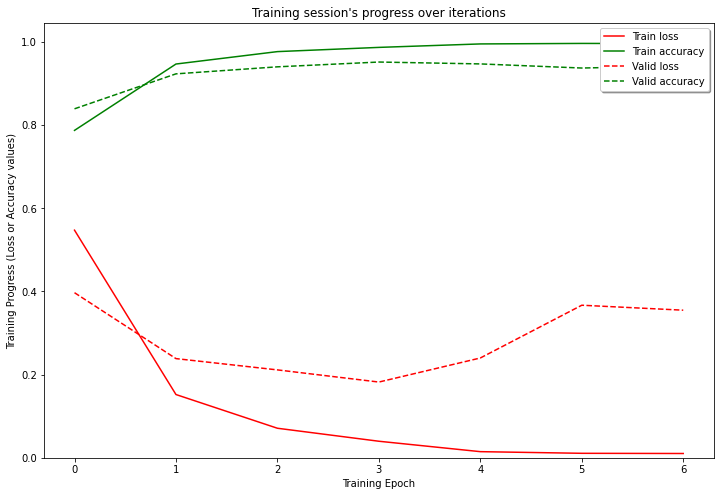

In [221]:
print(model_history.history.keys())
plt.figure(figsize=(12, 8))
plt.plot(np.array(model_history.history['loss']), "r-", label="Train loss")
plt.plot(np.array(model_history.history['accuracy']), "g-", label="Train accuracy")
plt.plot(np.array(model_history.history['val_loss']), "r--", label="Valid loss")
plt.plot(np.array(model_history.history['val_accuracy']), "g--", label="Valid accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

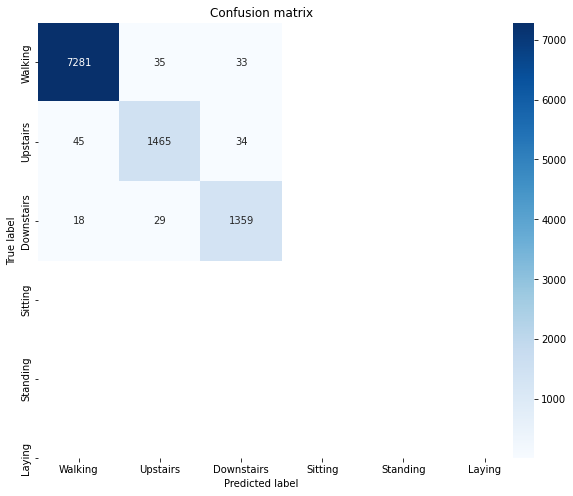

In [267]:
LABELS = ['Walking','Upstairs','Downstairs','Sitting','Standing','Laying']
Y_cat = np.argmax(Y, axis=1)
Y_pred_cat = np.argmax(Y_pred, axis=1)
confusion_matrix = metrics.confusion_matrix(Y_cat, Y_pred_cat)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

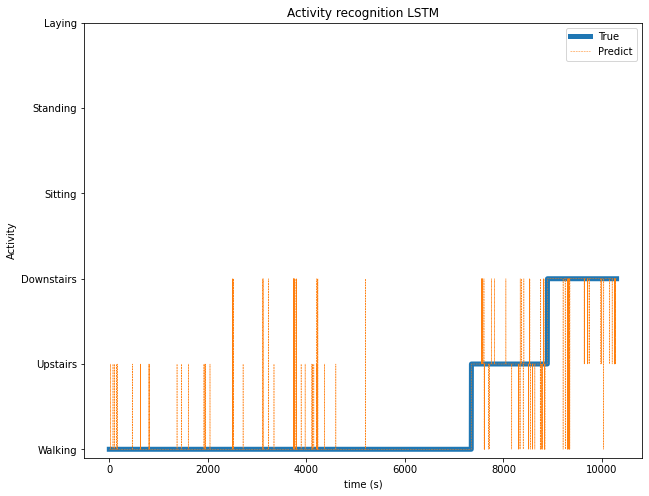

In [219]:
def visualize_activity_recognition(t, label_true, label_pred_mode, label_classes,name):
    plt.figure(figsize=(10, 8))
    plt.title("Activity recognition {}".format(name))
    plt.plot(t, label_true, linewidth=5.0)
    plt.plot(t.reshape(-1), label_pred_mode.reshape(-1), '--', linewidth=0.50)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    plt.xlabel("time (s)")
    plt.ylabel("Activity")
    plt.legend(["True", "Predict"])
    plt.show()

num = len(Y_cat)
t = np.arange(0,num*1,1)
visualize_activity_recognition(t, Y_cat, Y_pred_cat, LABELS,"LSTM")

In [11]:
pickle.dump([trainX, trainy, testX, testy, X, Y, Y_pred, Y_pred_cat, Y_cat], open("drive/MyDrive/Thesis/Test Data/LSTM_HAR_stairs_Results", "wb"))
print("Saved model to disk")

Saved model to disk


In [325]:
# load data from saved matlab file
D = loadmat("drive/MyDrive/Thesis/Codes/Stairs/14U 14D/results.mat")
print(D.keys())

aC = D['aC50']
aCtot = D['aCtot50']
gC = D['gyroC50']
myY = D['des50']

myX = np.append(aCtot,aC,axis=1)
myX = np.append(myX,gC,axis=1)

myX = gC
myX[:,0] = gC[:,0]
myX[:,1] = gC[:,1]
myX[:,2] = gC[:,2]*2

print(myX.shape)
print(myY.shape)


dict_keys(['__header__', '__version__', '__globals__', 'aC50', 'aCtot50', 'des50', 'gyroC50'])
(4928, 3)
(4928, 1)


In [326]:
# reshape data to input of Net
N_TIME_STEPS = 128
step = 64 # faster with bigger step but accuracy degrades fast
X_my = []
Y_my = []
for i in range(0, len(myY) - N_TIME_STEPS, step):
    part = myX[i: i + N_TIME_STEPS]
    label = stats.mode(myY[i: i + N_TIME_STEPS])[0][0]
    X_my.append(part)
    Y_my.append(label)
Y_binary_my = to_categorical(Y_my) 
X_my = np.array(X_my)
Y_binary_my = np.array(Y_binary_my)
print(X_my.shape)

# reshape data into time steps of sub-sequences
n_features, n_steps, n_length = X_my.shape[2], 4, 32
X_my = X_my.reshape((X_my.shape[0], n_steps, 1, n_length, n_features))
Y_cat_my = np.argmax(Y_binary_my, axis=1)
Y_pred_my = model.predict(np.array(X_my))
np.shape(Y_pred_my)
Y_pred_cat_my = np.argmax(Y_pred_my, axis=1)

(75, 128, 3)


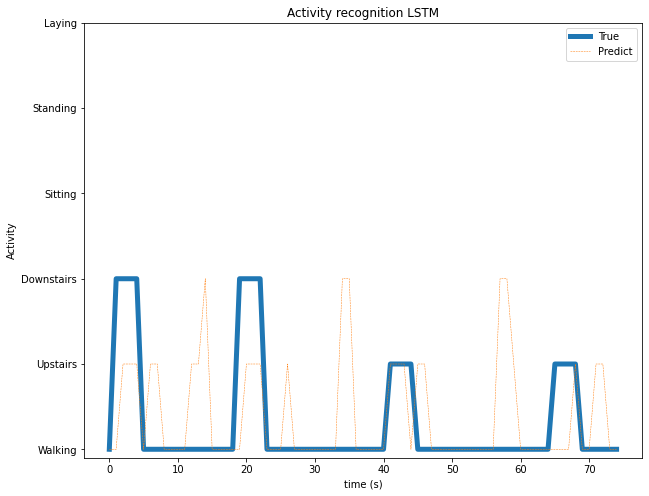

In [327]:
num = len(Y_my)
t = np.arange(0,num*1,1)
visualize_activity_recognition(t, Y_my, Y_pred_cat_my, LABELS,"LSTM")